In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy
import scipy.io as sio
import torch
import torch.nn.functional as F
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR, LinearLR

from splice import splice_model
from splice.base import *
from splice.loadCellsFile import *
from splice.utilities import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Harris_Lab\miniconda3\envs\splice\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-26 00:29:29,465	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-26 00:29:30,400	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Preprocessing
The preprocessing code below is adapted from Carlos' notebook, with minor changes to variable names, using numpy instead of pandas, and slight optimizations

### Load the data

In [17]:
ratname = "A324"
sessdate = "2023_07_21"

session_info = mat2pyCellFileCleanup("../data/uberphys/%s_%s.mat" % (ratname, sessdate))
session_data = scipy.io.loadmat("../data/uberphys/%s_%s.mat" % (ratname, sessdate)) 

included_trials = np.argwhere((session_info["Trials"]['violated'] == 0) & ((~np.isnan(session_info["Trials"]["pokedR"])))).squeeze()
n_trials = included_trials.shape[0]
cpoke_in = session_info["Trials"]["stateTimes"]["cpoke_in"][included_trials]
cpoke_out = session_info["Trials"]["stateTimes"]["cpoke_out"][included_trials]

included_cells = np.argwhere(session_data['standard_inclusion_criteria'].squeeze()).squeeze()
brain_region = np.array(session_info['region'])[included_cells]

print(f"We have {n_trials} non-violation, valid trials")

KeyboardInterrupt: 

### Bin and smooth firing rates
Here we bin spikes into 10 ms bins; then smooth with a 60ms sd Gaussian; then subsample down by 3.

We end up with **time_in_session**, a time in session vector, and **smoothed_rates**, an nCells x nTimebins matrix of smoothed firing rates (no trial structure yet)

In [ ]:
spike_times= session_data['raw_spike_time_s'].squeeze()[included_cells]
n_cells = spike_times.shape[0]
print(f"We have {n_cells} cells total")

We have 2621 cells total


In [ ]:
min_time = np.inf
max_time = -np.inf

for cell in spike_times:
    if len(cell) > 0:
        min_time = min(min_time, cell[0])
        max_time = max(max_time, cell[-1])

min_time = min_time[0] # type: ignore
max_time = max_time[0] # type: ignore
print(f"Min time: {min_time}, Max time: {max_time}")
    

Min time: 1658.66378, Max time: 14362.02429


In [ ]:
dt = 0.01
bin_times = np.arange(np.floor(min_time), np.ceil(max_time), dt)
smooth_sigma = 0.06 # in seconds
subsample_factor = 3

filepath = f"../data/uberphys/%s_%s_%.3f_smoothed_rates.npz" % (ratname, sessdate, smooth_sigma)

if(os.path.exists(filepath)):
    data = np.load(filepath)
    smoothed_rates = data['smoothed_rates']
    time_in_session = data['time_in_session']
    print("Loaded smoothed rates from file")
else:
    time_in_session = bin_times[0:-1:subsample_factor]
    smoothed_rates = np.zeros((n_cells, len(time_in_session)))

    for cell in range(n_cells):
        if smooth_sigma == 0:
            smoothed_rates[cell] = binEvents(spike_times[cell], bin_times, dt)[0:-1:subsample_factor]/dt
        else:
            smoothed_rates[cell] = smoothIt(binEvents(spike_times[cell], bin_times, dt), smooth_sigma/dt)[0:-1:subsample_factor]/dt
        
        print(f"Done with {cell+1}/{n_cells} cells", end="\r")
    
    np.savez_compressed(filepath, smoothed_rates=smoothed_rates, time_in_session=time_in_session)

Loaded smoothed rates from file


### Put times into trials

We'll make a tensor **trial_rates**, nTrials x nCells x nTimebins, where nTimebins now just runs over `cpoke_in` to `cpoke_out`.

Note that different trials are different lengths.  We're timelocked to `cpoke_in`, but some will have `np.nan`s in their last timebins

In [ ]:
trial_length = 0.5

trial_rates = np.zeros((n_trials, n_cells, int(np.ceil(trial_length/(dt*subsample_factor)))))
trial_times = list(np.arange(trial_rates.shape[-1])*(dt*subsample_factor))

for trial in range(n_trials):
    start = cpoke_in[trial]
    end = cpoke_out[trial]

    rates = smoothed_rates[:, (time_in_session >= start) & (time_in_session < end)]

    if rates.shape[1] > trial_rates.shape[-1]:
        add_length = rates.shape[1] - trial_rates.shape[-1]
        trial_rates = np.concatenate((trial_rates, np.nan * np.zeros((n_trials, n_cells, add_length))), axis=-1)

        new_times = list(trial_times[-1] + np.arange(1, (add_length+1))*(dt*subsample_factor))

        if new_times:
            trial_times.extend(new_times)
    
    trial_rates[trial, :, :rates.shape[1]] = rates

trial_times = np.array(trial_times)

## Autoencoder vs PCA

### Pick out cells from a brain region (Cg1)

In [ ]:
np.unique(brain_region)

array(['ADS', 'CC', 'Cg1', 'DGd', 'DGv', 'DS', 'GP', 'M1', 'M2', 'MGB',
       'NAc', 'None', 'PrL', 'S1', 'SBN', 'TS'], dtype='<U4')

In [ ]:
selected_region = "Cg1"
selected_cells = np.argwhere(brain_region == selected_region).squeeze()

selected_spike_times = spike_times[selected_cells]
selected_smoothed_rates = smoothed_rates[selected_cells]
n_cells_selected = selected_spike_times.shape[0]
print(f"We have {selected_spike_times.shape[0]} cells in {selected_region}")

We have 305 cells in Cg1


In [ ]:
train_data, test_data = train_test_split(trial_rates[:, selected_cells, :], test_size=0.15)

train_data = train_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
train_data = train_data[~np.isnan(train_data).any(axis=1)]

test_data = test_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
test_data = test_data[~np.isnan(test_data).any(axis=1)]

NameError: name 'selected_cells' is not defined

### Do PCA

In [14]:
filepath = "../data/uberphys/split_rates.npz"
split_rates = np.load(filepath)
train_ads = split_rates['train_ads']
train_m1 = split_rates['train_m1']
test_ads = split_rates['test_ads']
test_m1 = split_rates['test_m1']

In [32]:
pca = PCA(n_components=train_ads.shape[1])
pca.fit(train_ads)

PCA(n_components=318)

In [35]:
mse = np.zeros(20)

for i in range(20):
    test_pcs = pca.transform(test_ads)
    test_pcs[:, i+1:] = 0
    test_proj = pca.inverse_transform(test_pcs)

    mse[i] = torch.nn.functional.mse_loss(torch.tensor(test_proj), torch.tensor(test_ads))

In [38]:
ae_accs = [17.237, 16.143, 14.731, 13.346, 10.575, 9.385, 8.779]

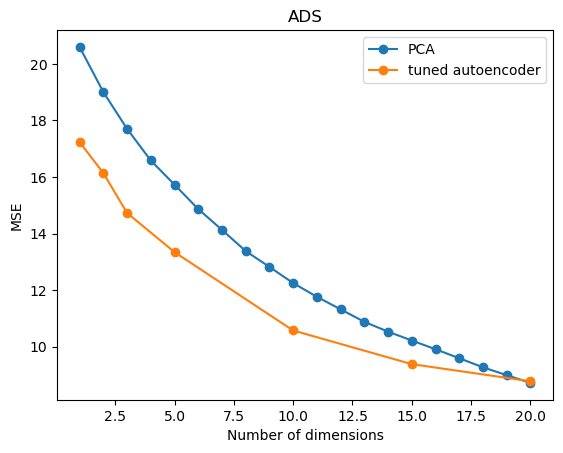

In [39]:
plt.plot(np.arange(20)+1, mse, marker='o', label="PCA");
plt.plot(np.array([0,1,2,4,9,14,19])+1, ae_accs, marker='o', label="tuned autoencoder");
plt.xlabel("Number of dimensions")
plt.ylabel("MSE");
plt.legend();
plt.title("ADS")

plt.savefig("../results/uberphys/pca_ae_comparison/ADS_pca_vs_tuned_ae.png",dpi=300)


In [ ]:
s1 = np.var(test_data - train_data.mean(axis=0))
s2 = np.var(test_data)
test_var_explained = 1 - s1/s2
print(f"Variance explained by mean: {test_var_explained}")

Variance explained by mean: 0.480078345688685


Text(0, 0.5, 'Cumulative Variance Explained')

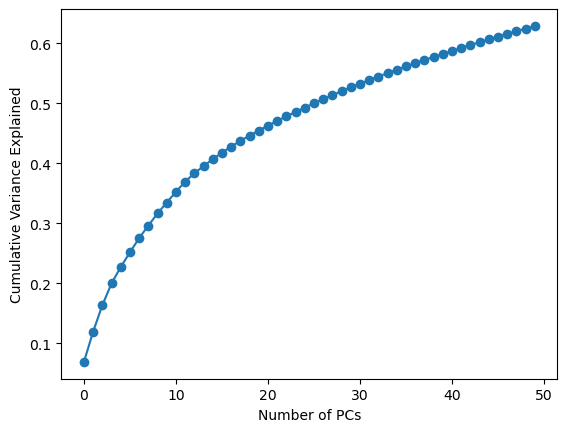

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:50], marker='o'); 
plt.xlabel("Number of PCs"); plt.ylabel("Cumulative Variance Explained")

In [ ]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

for dim in [2,3,5,10,20, 50]:
    test_pcs = pca.transform(test_data)
    test_pcs[:, dim:] = 0
    test_proj = pca.inverse_transform(test_pcs)

    s1 = np.var(test_data-test_proj)
    s2 = np.var(test_data - test_data.mean(axis=0))
    test_var_explained = 1 - s1/s2

    print(f"With {dim} PCs, we can explain {explained_variance[dim-1]:.4f} of the training variance and {test_var_explained:.4f} of the test variance. The MSE is {F.mse_loss(torch.Tensor(test_proj),torch.Tensor(test_data)):.4f}")

With 2 PCs, we can explain 0.1194 of the training variance and 0.1158 of the test variance. The MSE is 22.6690
With 3 PCs, we can explain 0.1635 of the training variance and 0.1592 of the test variance. The MSE is 21.5559
With 5 PCs, we can explain 0.2272 of the training variance and 0.2244 of the test variance. The MSE is 19.8842
With 10 PCs, we can explain 0.3347 of the training variance and 0.3228 of the test variance. The MSE is 17.3596
With 20 PCs, we can explain 0.4548 of the training variance and 0.4446 of the test variance. The MSE is 14.2386
With 50 PCs, we can explain 0.6293 of the training variance and 0.6151 of the test variance. The MSE is 9.8667


In [ ]:
explained_variance[0]

0.06880606394176564

### Do Autoencoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, nInputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Encoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.encoderLayers  = nn.ModuleList()
        self.nInputCells    = nInputCells

        for i in range(self.nLayers):
            if i == 0:
                self.encoderLayers.append(nn.Linear(self.nInputCells, nHiddensVector[i]))
            else:
                self.encoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.encoderLayers.append(nonlinearity)

        self.encoderLayers.append(nn.Linear(nHiddensVector[-1], bottleneckDim))

    def forward(self, x):
        for layer in self.encoderLayers:
            x = layer(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, bottleneckDim, nHiddensVector, nOutputCells,
                 nonlinearity = nn.ReLU()):
        super(Decoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.decoderLayers  = nn.ModuleList()
        self.nOutputCells   = nOutputCells

        for i in range(self.nLayers):
            if i == 0:
                self.decoderLayers.append(nn.Linear(bottleneckDim, nHiddensVector[i]))
            else:
                self.decoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.decoderLayers.append(nonlinearity)

        self.decoderLayers.append(nn.Linear(nHiddensVector[-1], nOutputCells))

    def forward(self, x):
        for layer in self.decoderLayers:
            x = layer(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, nInputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(nInputCells, nHiddensVector, bottleneckDim, nonlinearity)
        self.decoder = Decoder(bottleneckDim, nHiddensVector[::-1], nInputCells, nonlinearity)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def trainAutoencoderWithValidation(model, data, nEpochs, learningRate, 
                                   lossFunction, optimizer, validationData,
                                   printEvery=100, verbose=True):
    
    scheduler = LinearLR(optimizer, start_factor=1, end_factor=1/10, total_iters=nEpochs)

    for epoch in range(nEpochs):
        print(epoch, end="\r")
        optimizer.zero_grad()
        output = model(data)
        loss = lossFunction(output, data)
        loss.backward()
        optimizer.step()

        scheduler.step()
        
        if verbose:
            if epoch % printEvery == 0:
                output = model(validationData)
                validationLoss = lossFunction(output, validationData)
                print("Epoch %d, Loss: %f, Validation loss: %f" % (epoch, loss.item(), validationLoss.item()))            
    return model

In [ ]:
model = Autoencoder(n_cells_selected, [100,50,50,50,20], 20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
lossFunction = nn.MSELoss()

train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

trainAutoencoderWithValidation(model, train_data_tensor, 25000, 0.001, lossFunction, optimizer, test_data_tensor, printEvery=100)

Epoch 0, Loss: 68.304047, Validation loss: 67.454216
Epoch 100, Loss: 25.759756, Validation loss: 25.433765
Epoch 200, Loss: 25.706358, Validation loss: 25.380646
Epoch 300, Loss: 25.693777, Validation loss: 25.367201
Epoch 400, Loss: 25.688129, Validation loss: 25.361633
Epoch 500, Loss: 25.682161, Validation loss: 25.356152
Epoch 600, Loss: 25.672859, Validation loss: 25.347681
Epoch 700, Loss: 25.653549, Validation loss: 25.329933
Epoch 800, Loss: 25.573576, Validation loss: 25.254227
Epoch 900, Loss: 25.369173, Validation loss: 25.033264
Epoch 1000, Loss: 23.827751, Validation loss: 23.561522
Epoch 1100, Loss: 23.133062, Validation loss: 22.932308
Epoch 1200, Loss: 22.586386, Validation loss: 22.443880
Epoch 1300, Loss: 22.418783, Validation loss: 22.023981
Epoch 1400, Loss: 21.198013, Validation loss: 21.129887
Epoch 1500, Loss: 20.791790, Validation loss: 20.712593
Epoch 1600, Loss: 21.021891, Validation loss: 20.474222
Epoch 1700, Loss: 20.227757, Validation loss: 20.120094
Epoc

Autoencoder(
  (encoder): Encoder(
    (encoderLayers): ModuleList(
      (0): Linear(in_features=305, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): ReLU()
      (8): Linear(in_features=50, out_features=20, bias=True)
      (9): ReLU()
      (10): Linear(in_features=20, out_features=20, bias=True)
    )
  )
  (decoder): Decoder(
    (decoderLayers): ModuleList(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): ReLU()
      (8): Linear(in_features=50, out_features=100, bias=True)
      (9): ReLU()


In [ ]:
def explainedVariance(data, model, train_data):
    mu = train_data.mean(axis=0).cpu().detach().numpy()
    return 1 - np.var((data - model(data)).cpu().detach().numpy())/np.var(data.cpu().detach().numpy()-mu)
# remainingVar = np.var((testData-model(testData)).cpu().detach().numpy())
# totalVar = np.var(testData.cpu().detach().numpy()-mu)
# fracExplainedVar = 1 - remainingVar/totalVar

bottleneckDim = 2

print("bottleneckDim=%d: frac test data variance explained: " % bottleneckDim, explainedVariance(test_data_tensor, model, train_data_tensor))
print("bottleneckDim=%d: frac train data variance explained: " % bottleneckDim, explainedVariance(train_data_tensor, model, train_data_tensor))

bottleneckDim=2: frac test data variance explained:  0.41604405641555786
bottleneckDim=2: frac train data variance explained:  0.44479167461395264


### Automate PCA-Autoencoder comparison

In [ ]:
def compare_pca_ae(selected_region, brain_region, trial_rates, ae_dims=[1,2,3,5,10,20,50], max_dim = 50):
    ae_dims = np.array(ae_dims)
    ae_dims = ae_dims[ae_dims <= max_dim]

    # select cells and trials
    selected_cells = np.argwhere(brain_region == selected_region).squeeze()
    n_cells_selected = selected_cells.shape[0]
    print(f"We have {selected_cells.shape[0]} cells in {selected_region}")

    train_data, test_data = train_test_split(trial_rates[:, selected_cells, :], test_size=0.15)

    train_data = train_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
    train_data = train_data[~np.isnan(train_data).any(axis=1)]

    test_data = test_data.transpose(0, 2, 1).reshape(-1, n_cells_selected)
    test_data = test_data[~np.isnan(test_data).any(axis=1)]

    # Do PCA
    pca = PCA(n_components=n_cells_selected)
    pca.fit(train_data)

    pca_var_explained = np.zeros(min(max_dim, n_cells_selected))
    for dim in range(1,min(max_dim, n_cells_selected)+1):
        test_pcs = pca.transform(test_data)
        test_pcs[:, dim:] = 0
        test_proj = pca.inverse_transform(test_pcs)

        s1 = np.var(test_data-test_proj)
        s2 = np.var(test_data - train_data.mean(axis=0))
        pca_var_explained[dim-1] = 1 - s1/s2

    # Do AE
    ae_var_explained = np.zeros(len(ae_dims))

    for i, dim in enumerate(ae_dims):
        #train 
        print(f"Training {dim}-dimensional autoencoder")
        model = Autoencoder(n_cells_selected, [100,50,50,50,20], dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
        lossFunction = nn.MSELoss()

        train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
        test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)

        trainAutoencoderWithValidation(model, train_data_tensor, 25000, 0.001, lossFunction, optimizer, test_data_tensor, printEvery=100, verbose=False)

        ae_var_explained[i] = explainedVariance(test_data_tensor, model, train_data_tensor)

    plt.figure()
    plt.title(f"Explained variance in {selected_region}")
    plt.plot(np.arange(0,min(max_dim, n_cells_selected)+1), np.concatenate(([0], pca_var_explained)), label="PCA", marker='o')
    plt.plot(np.concatenate(([0],ae_dims)), np.concatenate(([0], ae_var_explained)), label="AE", marker='o')
    plt.legend()
    plt.xlabel("Number of dimensions")
    plt.ylabel("Explained variance")
    plt.ylim(0,1)


    plt.savefig(f"../results/uberphys/pca_ae_comparison/{selected_region}_pca_ae.png")
    np.savez_compressed(
        f"../results/uberphys/pca_ae_comparison/{selected_region}_pca_ae", 
        pca_var_explained=pca_var_explained, 
        ae_var_explained=ae_var_explained, 
        ae_dims=ae_dims
        )

    return pca_var_explained, ae_var_explained
    

Processing ADS
We have 318 cells in ADS
Training 1-dimensional autoencoder
Training 2-dimensional autoencoder
Training 3-dimensional autoencoder
Training 5-dimensional autoencoder
Training 10-dimensional autoencoder
Training 20-dimensional autoencoder
Processing CC
We have 53 cells in CC
Training 1-dimensional autoencoder
Training 2-dimensional autoencoder


KeyboardInterrupt: 

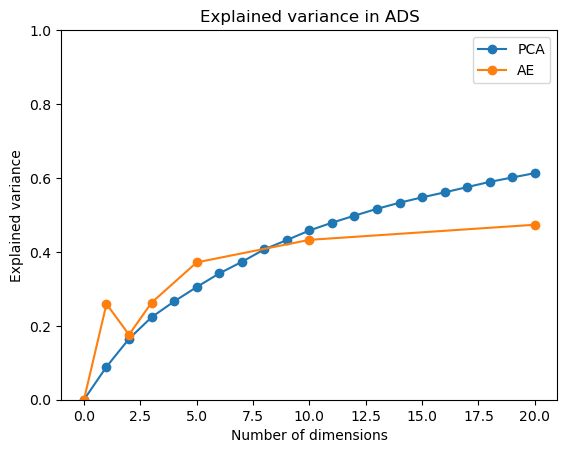

In [ ]:
for region in np.unique(brain_region):
    if region != "None":
        print(f"Processing {region}")
        compare_pca_ae(region, brain_region, trial_rates, max_dim=20)

## RRR vs Cross-encoder

In [52]:
# train_data, test_data = train_test_split(trial_rates[:, :, :], test_size=0.15) #random trial split
test_inds = np.arange(n_trials, step=6)
train_inds = np.array([i for i in range(n_trials) if i not in test_inds])

train_data = trial_rates[train_inds, :, :]
test_data = trial_rates[test_inds, :, :]

# select cells and trials
ads_cells = np.argwhere(brain_region == "ADS").squeeze()
n_cells_ads = ads_cells.shape[0]
print(f"We have {ads_cells.shape[0]} cells in ADS")

m1_cells = np.argwhere(brain_region == "M1").squeeze()
n_cells_m1 = m1_cells.shape[0]
print(f"We have {m1_cells.shape[0]} cells in M1")

train_ads = train_data[:, ads_cells, :].transpose(0,2,1).reshape(-1, n_cells_ads)
train_m1 = train_data[:, m1_cells, :].transpose(0,2,1).reshape(-1, n_cells_m1)
train_ads = train_ads[~np.isnan(train_ads).any(axis=1)]
train_m1 = train_m1[~np.isnan(train_m1).any(axis=1)]

test_ads = test_data[:, ads_cells, :].transpose(0,2,1).reshape(-1, n_cells_ads)
test_m1 = test_data[:, m1_cells, :].transpose(0,2,1).reshape(-1, n_cells_m1)
test_ads = test_ads[~np.isnan(test_ads).any(axis=1)]
test_m1 = test_m1[~np.isnan(test_m1).any(axis=1)]

We have 318 cells in ADS
We have 149 cells in M1


In [53]:
test_inds

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708])

In [54]:
filepath = f"../data/uberphys/split_rates.npz"
np.savez_compressed(filepath, train_ads=train_ads, train_m1=train_m1, test_ads=test_ads, test_m1=test_m1)


### RRR

In [55]:
class RRR(nn.Module):
    def __init__(self, n_inputs, n_outputs, bottle_dim):
        super().__init__()

        self.encoder = nn.Linear(n_inputs, bottle_dim)
        self.decoder = nn.Linear(bottle_dim, n_outputs)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat

In [56]:
train_ads = torch.Tensor(train_ads).to(device)
test_ads = torch.Tensor(test_ads).to(device)

train_m1 = torch.Tensor(train_m1).to(device)
test_m1 = torch.Tensor(test_m1).to(device)

In [57]:
dims = [1,2,3,5,10,15,20,30,50]
accs = np.zeros((len(dims)))

for i, dim in enumerate(dims):
    print(f"DIM {dim}")
    rrr = RRR(n_cells_m1, n_cells_ads, dim).to(device)

    optimizer = torch.optim.Adam(rrr.parameters(), lr=0.003)
    lossFunction = nn.MSELoss()
    n_epochs = 25000

    for epoch in range(n_epochs):
        print(epoch, end="\r")
        optimizer.zero_grad()
        output = rrr(train_m1)
        loss = lossFunction(output, train_ads)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            output = rrr(test_m1)
            validationLoss = lossFunction(output, test_ads)
            print("Epoch %d, Loss: %f, Validation loss: %f" % (epoch, loss.item(), validationLoss.item()))  

            accs[i] = validationLoss


DIM 1
Epoch 0, Loss: 84.030609, Validation loss: 67.692261
Epoch 100, Loss: 40.575974, Validation loss: 40.243626
Epoch 200, Loss: 36.717140, Validation loss: 36.409218
Epoch 300, Loss: 28.661217, Validation loss: 28.465431
Epoch 400, Loss: 23.759840, Validation loss: 23.734735
Epoch 500, Loss: 22.950386, Validation loss: 22.975790
Epoch 600, Loss: 22.790028, Validation loss: 22.840809
Epoch 700, Loss: 22.758446, Validation loss: 22.820974
Epoch 800, Loss: 22.751778, Validation loss: 22.819433
Epoch 900, Loss: 22.749643, Validation loss: 22.819490
Epoch 1000, Loss: 22.748335, Validation loss: 22.819157
Epoch 1100, Loss: 22.747175, Validation loss: 22.818476
Epoch 1200, Loss: 22.746016, Validation loss: 22.817587
Epoch 1300, Loss: 22.744810, Validation loss: 22.816565
Epoch 1400, Loss: 22.743534, Validation loss: 22.815434
Epoch 1500, Loss: 22.742184, Validation loss: 22.814203
Epoch 1600, Loss: 22.740746, Validation loss: 22.812885
Epoch 1700, Loss: 22.739220, Validation loss: 22.81148

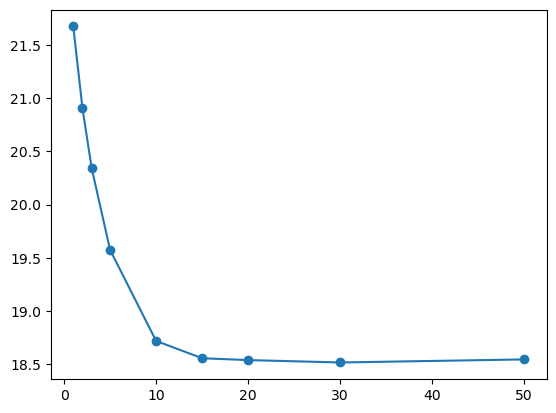

In [58]:
plt.plot(dims, accs, marker='o');

In [59]:
mu = train_ads.mean(dim=0).cpu().detach().numpy()
var = 1 - np.var((test_ads - rrr(test_m1)).cpu().detach().numpy())/np.var(test_ads.cpu().detach().numpy()-mu)
var

0.18993103504180908

### cross encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, nInputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Encoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.encoderLayers  = nn.ModuleList()
        self.nInputCells    = nInputCells

        for i in range(self.nLayers):
            if i == 0:
                self.encoderLayers.append(nn.Linear(self.nInputCells, nHiddensVector[i]))
            else:
                self.encoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.encoderLayers.append(nonlinearity)

        self.encoderLayers.append(nn.Linear(nHiddensVector[-1], bottleneckDim))

    def forward(self, x):
        for layer in self.encoderLayers:
            x = layer(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, bottleneckDim, nHiddensVector, nOutputCells,
                 nonlinearity = nn.ReLU()):
        super(Decoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.decoderLayers  = nn.ModuleList()
        self.nOutputCells   = nOutputCells

        for i in range(self.nLayers):
            if i == 0:
                self.decoderLayers.append(nn.Linear(bottleneckDim, nHiddensVector[i]))
            else:
                self.decoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.decoderLayers.append(nonlinearity)

        self.decoderLayers.append(nn.Linear(nHiddensVector[-1], nOutputCells))

    def forward(self, x):
        for layer in self.decoderLayers:
            x = layer(x)
        return x
    
class Crossencoder(nn.Module):
    def __init__(self, nInputCells, nOutputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Crossencoder, self).__init__()

        self.encoder = Encoder(nInputCells, nHiddensVector, bottleneckDim, nonlinearity)
        self.decoder = Decoder(bottleneckDim, nHiddensVector[::-1], nOutputCells, nonlinearity)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def trainCrossencoderWithValidation(model, input_data, output_data, nEpochs,
                                   lossFunction, optimizer, validationInputData, validationOutputData,
                                   printEvery=100, verbose=True):
    
    # scheduler = LinearLR(optimizer, start_factor=1, end_factor=1/100, total_iters=nEpochs)
    train_loss = np.zeros(nEpochs//printEvery)
    test_loss = np.zeros(nEpochs//printEvery)

    for epoch in range(nEpochs):
        print(epoch, end="\r")
        optimizer.zero_grad()
        output = model(input_data)
        loss = lossFunction(output, output_data)
        loss.backward()
        optimizer.step()

        # scheduler.step()
        
        if epoch % printEvery == 0:
            output = model(validationInputData)
            validationLoss = lossFunction(output, validationOutputData)

            train_loss[epoch//printEvery] = loss.item()
            test_loss[epoch//printEvery] = validationLoss.item()

            if verbose:
                print("Epoch %d, Loss: %f, Validation loss: %f" % (epoch, loss.item(), validationLoss.item()))            

    return train_loss, test_loss

In [ ]:
train_m1.shape

torch.Size([34043, 149])

In [ ]:
# stratify train test split by time
# cross-validate
# try dims between 5 and 10
# subtract baseline?


dims = [1,2,3,5,10,15,20]
archs = [
    [[20]*6, False], 
    [[20]*5, False],
    [[20]*5, 0.001],
    [[20]*5, False],
    [[20]*4, 0.001],
    [[20]*3, 0.001],
    [[20], 0.005],
]

n_epochs = 10000
train_losses = np.zeros((len(dims)*len(archs),n_epochs//100))
test_losses = np.zeros((len(dims)*len(archs),n_epochs//100))



for i, dim in enumerate(dims):
    for j, arch in enumerate(archs):
        print(f"DIM {dim} with hidden layers {arch[0]} and weight decay {arch[1]}")

        crossencoder = Crossencoder(n_cells_m1, n_cells_ads, arch[0], dim).to(device)
        if arch[1] == False:
            optimizer = torch.optim.Adam(crossencoder.parameters(), lr=0.003)
        else:
            optimizer = torch.optim.Adam(crossencoder.parameters(), lr=0.003, weight_decay=arch[1])
            
        lossFunction = nn.MSELoss()

        train_losses[3*i+j], test_losses[3*i+j] = trainCrossencoderWithValidation(
            crossencoder, 
            train_m1, 
            train_ads, 
            n_epochs, 
            lossFunction, 
            optimizer, 
            test_m1, 
            test_ads, 
            printEvery=100
            )

DIM 1 with hidden layers [20, 20, 20, 20, 20, 20] and weight decay False
Epoch 0, Loss: 40.961857, Validation loss: 40.580147
Epoch 100, Loss: 22.790684, Validation loss: 22.822180
Epoch 200, Loss: 22.732203, Validation loss: 22.793358
Epoch 300, Loss: 22.709145, Validation loss: 22.782391
Epoch 400, Loss: 22.688757, Validation loss: 22.773701
Epoch 500, Loss: 22.670540, Validation loss: 22.763742
Epoch 600, Loss: 22.204203, Validation loss: 22.315832
Epoch 700, Loss: 21.667124, Validation loss: 21.708708
Epoch 800, Loss: 21.417933, Validation loss: 21.482344
Epoch 900, Loss: 21.139126, Validation loss: 21.400955
Epoch 1000, Loss: 20.881721, Validation loss: 21.194876
Epoch 1100, Loss: 20.616796, Validation loss: 20.995049
Epoch 1200, Loss: 20.473963, Validation loss: 20.872219
Epoch 1300, Loss: 20.372913, Validation loss: 20.775572
Epoch 1400, Loss: 20.179913, Validation loss: 20.632647
Epoch 1500, Loss: 20.083111, Validation loss: 20.533882
Epoch 1600, Loss: 19.981882, Validation los

In [ ]:
lossFunction(test_ads, train_ads.mean(dim=0))

c:\Users\Harris_Lab\miniconda3\envs\splice\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([318])) that is different to the input size (torch.Size([6736, 318])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(22.8960, device='cuda:0')

In [ ]:
train_losses.min(axis=1)[0:train_losses.shape[0]:3].shape

(7,)

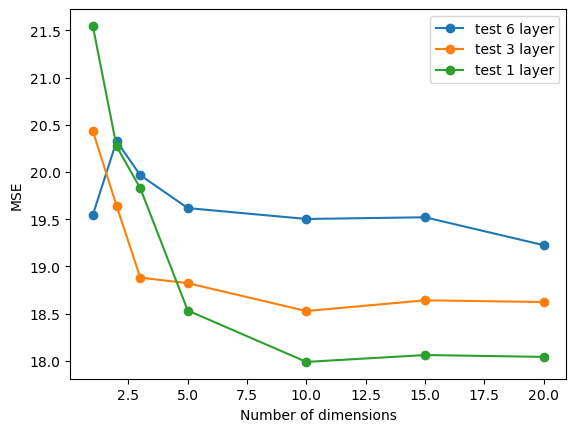

In [ ]:
# plt.plot(dims, train_losses.min(axis=1)[0:train_losses.shape[0]:3], marker='o', label='train')
plt.plot(dims, test_losses.min(axis=1)[0:train_losses.shape[0]:3], marker='o', label='test 6 layer')
plt.plot(dims, test_losses.min(axis=1)[1:train_losses.shape[0]:3], marker='o', label='test 3 layer')
plt.plot(dims, test_losses.min(axis=1)[2:train_losses.shape[0]:3], marker='o', label='test 1 layer')
plt.legend()
plt.xlabel("Number of dimensions")
plt.ylabel("MSE")
plt.savefig("../results/uberphys/crossencoder/0.003_10000_timesplit_best-arch.png")

In [ ]:
best_loss_per_dim = test_losses.min(axis=1).reshape(-1,3).min(axis=1)

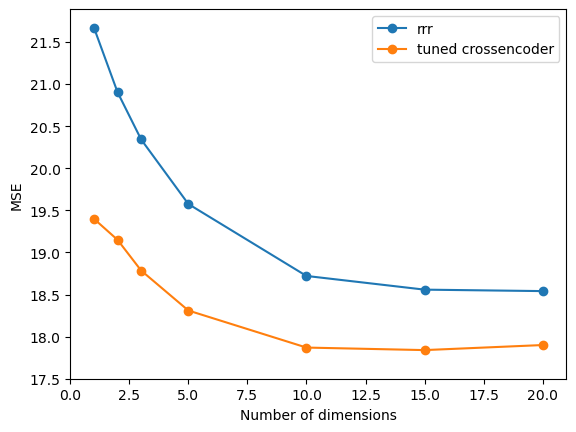

In [61]:
from cProfile import label


plt.plot(dims[:-2], accs[:-2], marker='o', label='rrr');
plt.plot(dims[:-2], [19.4, 19.15, 18.785, 18.31, 17.87, 17.84, 17.9], marker='o', label='tuned crossencoder');
plt.legend()
plt.xlim(0,21); plt.ylim(17.5, 21.89)
plt.xlabel("Number of dimensions")
plt.ylabel("MSE")
plt.savefig("../results/uberphys/crossencoder/rrr-vs-ce_0.003_10000_timesplit_raytune.png")

In [ ]:
nHiddenVector = [40, 70, 60, 50, 40, 30, 20]

### More hyperparameter tuning

In [67]:
class Encoder(nn.Module):
    def __init__(self, nInputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Encoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.encoderLayers  = nn.ModuleList()
        self.nInputCells    = nInputCells

        for i in range(self.nLayers):
            if i == 0:
                self.encoderLayers.append(nn.Linear(self.nInputCells, nHiddensVector[i]))
            else:
                self.encoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.encoderLayers.append(nonlinearity)

        self.encoderLayers.append(nn.Linear(nHiddensVector[-1], bottleneckDim))

    def forward(self, x):
        for layer in self.encoderLayers:
            x = layer(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, bottleneckDim, nHiddensVector, nOutputCells,
                 nonlinearity = nn.ReLU()):
        super(Decoder, self).__init__()

        self.nHiddensVector = nHiddensVector
        self.nLayers        = len(nHiddensVector)
        self.bottleneckDim  = bottleneckDim
        self.decoderLayers  = nn.ModuleList()
        self.nOutputCells   = nOutputCells

        for i in range(self.nLayers):
            if i == 0:
                self.decoderLayers.append(nn.Linear(bottleneckDim, nHiddensVector[i]))
            else:
                self.decoderLayers.append(nn.Linear(nHiddensVector[i-1], nHiddensVector[i]))
            self.decoderLayers.append(nonlinearity)

        self.decoderLayers.append(nn.Linear(nHiddensVector[-1], nOutputCells))

    def forward(self, x):
        for layer in self.decoderLayers:
            x = layer(x)
        return x
    
class Crossencoder(nn.Module):
    def __init__(self, nInputCells, nOutputCells, nHiddensVector, bottleneckDim,
                 nonlinearity = nn.ReLU()):
        super(Crossencoder, self).__init__()

        self.encoder = Encoder(nInputCells, nHiddensVector, bottleneckDim, nonlinearity)
        self.decoder = Decoder(bottleneckDim, nHiddensVector[::-1], nOutputCells, nonlinearity)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def trainCrossencoderWithValidation(model, input_data, output_data, nEpochs,
                                   lossFunction, optimizer, validationInputData, validationOutputData,
                                   printEvery=100, verbose=True):
    
    # scheduler = LinearLR(optimizer, start_factor=1, end_factor=1/100, total_iters=nEpochs)
    train_loss = np.zeros(nEpochs//printEvery)
    test_loss = np.zeros(nEpochs//printEvery)

    for epoch in range(nEpochs):
        print(epoch, end="\r")
        optimizer.zero_grad()
        output = model(input_data)
        loss = lossFunction(output, output_data)
        loss.backward()
        optimizer.step()

        # scheduler.step()
        
        if epoch % printEvery == 0:
            output = model(validationInputData)
            validationLoss = lossFunction(output, validationOutputData)

            train_loss[epoch//printEvery] = loss.item()
            test_loss[epoch//printEvery] = validationLoss.item()

            if verbose:
                print("Epoch %d, Loss: %f, Validation loss: %f" % (epoch, loss.item(), validationLoss.item()))            

    return train_loss, test_loss

def train_ce(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    filepath = r"C:\Users\Harris_Lab\Projects\SPLICE\data\uberphys\split_rates.npz"
    split_rates = np.load(filepath)
    train_ads = torch.Tensor(split_rates['train_ads']).to(device)
    train_m1 = torch.Tensor(split_rates['train_m1']).to(device)
    test_ads = torch.Tensor(split_rates['test_ads']).to(device)
    test_m1 = torch.Tensor(split_rates['test_m1']).to(device)
    
    model = Crossencoder(train_m1.shape[1], train_ads.shape[1], [20]*config["n_layers"], 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])


    lossFunction = nn.MSELoss()
    for epoch in range(10000):
        print(epoch, end="\r")
        optimizer.zero_grad()
        output = model(train_m1)
        loss = lossFunction(output, train_ads)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            output = model(test_m1)
            validationLoss = lossFunction(output, test_ads)

            train.report({"loss": validationLoss.item()})

In [68]:
filepath = r"C:\Users\Harris_Lab\Projects\SPLICE\data\uberphys\split_rates.npz"
split_rates = np.load(filepath)

In [69]:
split_rates.keys()

KeysView(NpzFile 'C:\\Users\\Harris_Lab\\Projects\\SPLICE\\data\\uberphys\\split_rates.npz' with keys: train_ads, train_m1, test_ads, test_m1)

In [70]:
search_space = {
    "n_layers": tune.choice([1,2,3,4,5,6]),
    "lr": tune.loguniform(0.0001, 0.01),
    "weight_decay": tune.loguniform(1e-5, 0.1)
}


asha_scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
)

hyperopt_search = HyperOptSearch(search_space, metric="loss", mode="min")

2024-07-23 12:56:18,899	WARNING hyperopt_search.py:193 -- You passed a `space` parameter to <class 'ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch'> that contained unresolved search space definitions. <class 'ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch'> should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.


In [51]:
results = tune.run(
    train_ce, num_samples=300, search_alg=hyperopt_search, scheduler=asha_scheduler, resources_per_trial={"cpu":16, "gpu": 1}, stop={"training_iteration": 1000}
)

2024-07-22 17:34:51,702	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_ce pid=14124) 0


Trial name,loss
train_ce_34df6cc4,20.1531
train_ce_355a2c19,20.2021
train_ce_36950950,20.0791
train_ce_47776457,20.1266
train_ce_4d4b53e5,19.8546
train_ce_66705e0b,21.0678
train_ce_827e644f,20.8539
train_ce_ca952a37,20.5063
train_ce_d9f00cd5,19.9688
train_ce_f4d61f55,20.8011


1436m(train_ce pid=14124) 1
1736m(train_ce pid=14124) 15
2136m(train_ce pid=14124) 18
2336m(train_ce pid=14124) 22
2536m(train_ce pid=14124) 24
(train_ce pid=14124) 26
2936m(train_ce pid=14124) 27
3136m(train_ce pid=14124) 30
(train_ce pid=14124) 32
3536m(train_ce pid=14124) 33
3836m(train_ce pid=14124) 36
4036m(train_ce pid=14124) 39
4436m(train_ce pid=14124) 41
4736m(train_ce pid=14124) 45
5136m(train_ce pid=14124) 48
5436m(train_ce pid=14124) 52
5836m(train_ce pid=14124) 55
6036m(train_ce pid=14124) 59
6436m(train_ce pid=14124) 61
6736m(train_ce pid=14124) 65
7336m(train_ce pid=14124) 68
7536m(train_ce pid=14124) 74
8136m(train_ce pid=14124) 76
8436m(train_ce pid=14124) 82
8636m(train_ce pid=14124) 85
9036m(train_ce pid=14124) 87
9336m(train_ce pid=14124) 91
9636m(train_ce pid=14124) 94
9936m(train_ce pid=14124) 97
(train_ce pid=14124) 100
1036m(train_ce pid=14124) 101
1116m(train_ce pid=14124) 104
1146m(train_ce pid=14124) 112
1176m(train_ce pid=14124) 115
1216m(train_ce pid=14124)

2024-07-22 17:43:43,633	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


(train_ce pid=29200) 1202
1204m(train_ce pid=29200) 1203
1207m(train_ce pid=29200) 1205
1211m(train_ce pid=29200) 1208
1214m(train_ce pid=29200) 1212
1217m(train_ce pid=29200) 1215


2024-07-22 17:43:43,667	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Harris_Lab/ray_results/train_ce_2024-07-22_17-34-51' in 0.0334s.


1220m(train_ce pid=29200) 1218
1222m(train_ce pid=29200) 1221
1228m(train_ce pid=29200) 1223
1231m(train_ce pid=29200) 1229
1235m(train_ce pid=29200) 1232
1238m(train_ce pid=29200) 1236
1240m(train_ce pid=29200) 1239
1242m(train_ce pid=29200) 1241
1244m(train_ce pid=29200) 1243
1246m(train_ce pid=29200) 1245
1248m(train_ce pid=29200) 1247
1251m(train_ce pid=29200) 1249
1253m(train_ce pid=29200) 1252
1256m(train_ce pid=29200) 1254
1259m(train_ce pid=29200) 1257
1264m(train_ce pid=29200) 1260
1268m(train_ce pid=29200) 1265
1271m(train_ce pid=29200) 1269
1275m(train_ce pid=29200) 1272
1278m(train_ce pid=29200) 1276
1282m(train_ce pid=29200) 1279
1286m(train_ce pid=29200) 1283


2024-07-22 17:43:44,027	INFO tune.py:1041 -- Total run time: 532.32 seconds (531.92 seconds for the tuning loop).
2024-07-22 17:43:44,028	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)


1289m(train_ce pid=29200) 1287
1292m(train_ce pid=29200) 1290
1295m(train_ce pid=29200) 1293
1298m(train_ce pid=29200) 1296
1300m(train_ce pid=29200) 1299


2024-07-22 17:43:44,239	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_ce_37a2876c: FileNotFoundError('Could not fetch metrics for train_ce_37a2876c: both result.json and progress.csv were not found at C:/Users/Harris_Lab/ray_results/train_ce_2024-07-22_17-34-51/train_ce_37a2876c_11_lr=0.0005,n_layers=4,weight_decay=0.0004_2024-07-22_17-43-32')


In [47]:
a = results.get_best_trial("loss", "min", "last").last_result

In [48]:
a

{'loss': 20.175907135009766,
 'timestamp': 1721683826,
 'checkpoint_dir_name': None,
 'done': True,
 'training_iteration': 100,
 'trial_id': 'f1730c6d',
 'date': '2024-07-22_17-30-26',
 'time_this_iter_s': 0.3305172920227051,
 'time_total_s': 32.91625714302063,
 'pid': 30320,
 'hostname': 'SAIKO',
 'node_ip': '127.0.0.1',
 'config': {'lr': 0.006476246144087064,
  'n_layers': 2,
  'weight_decay': 0.0007397573929099267},
 'time_since_restore': 32.91625714302063,
 'iterations_since_restore': 100,
 'experiment_tag': '15_lr=0.0065,n_layers=2,weight_decay=0.0007'}